## Breast Cancer Prediction

In [1]:
# Loading libraries needed for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from numpy.random import RandomState
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
new_data = pd.read_csv('data/data_updated.csv', index_col=0)
print new_data.shape
new_data.head()

(456, 10)


,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0


### Class distribution

In [3]:
new_data['Class'].value_counts()

0    444
1     12
Name: Class, dtype: int64

The problem we are trying to solve in this analysis is breast cancer prediction. Based on the features available, we are going to predict whether the tumor a patient has is benign or malignant. One of the biggest challenges of this analysis is to deal with an imbalanced dataset

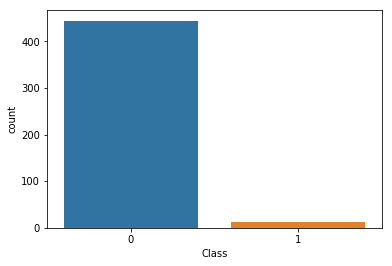

In [4]:
sns.countplot(new_data['Class'])

## Distribution of features over malignant and benign tumors

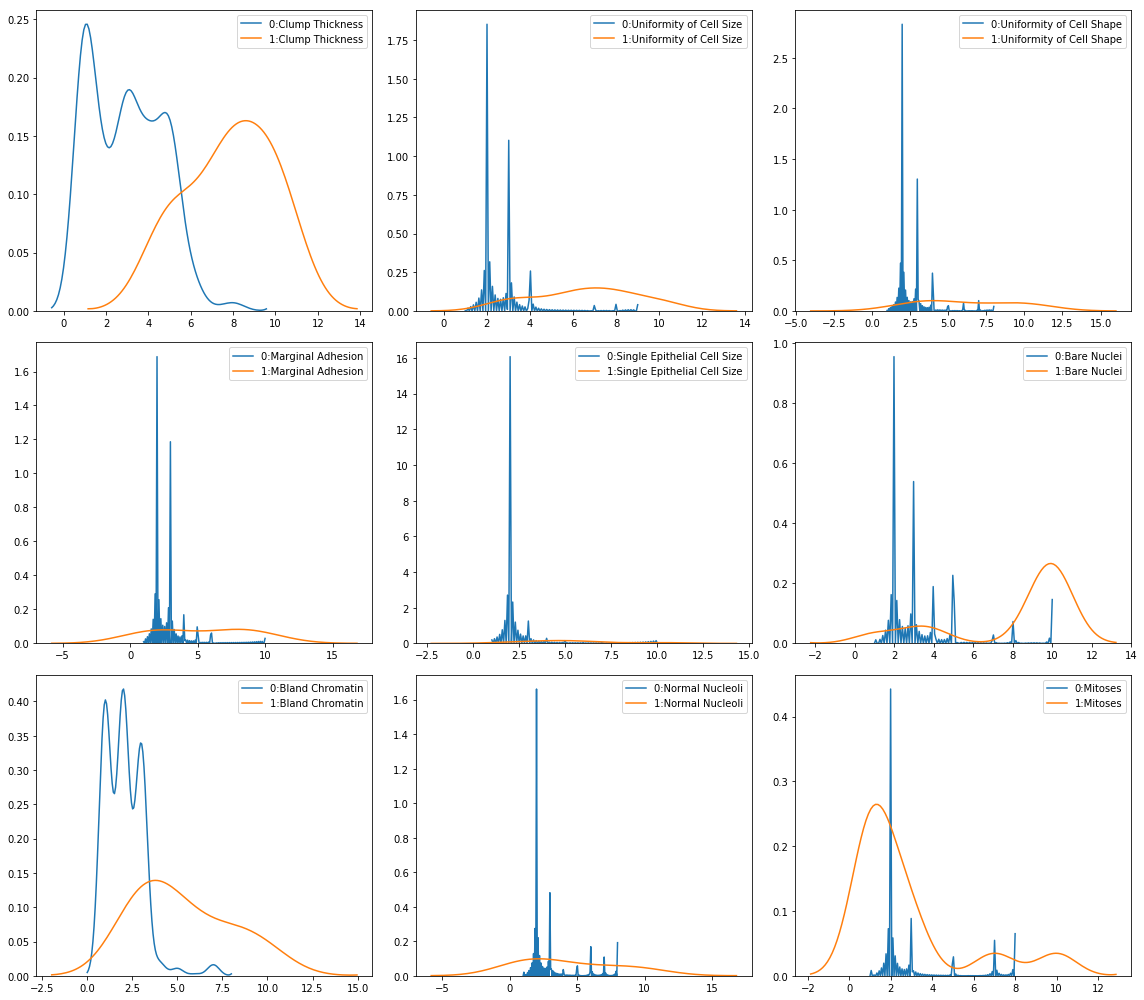

In [5]:
ccols = new_data.columns

grouped_data = new_data.groupby('Class')
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 14), 
                         tight_layout=True)
for ax, p in zip(axes.ravel(), ccols):
    for k, v in grouped_data[p]:
        sns.kdeplot(v, ax=ax, label=str(k)+":"+v.name)

In the kernel density plots I am looking for variables with very little overlap between the malignant and benign tumor. Out of nine features, only two features have high discriminatory power between class 0 and 1

Choosing the evaluation metrics is also quite challenging when dealing with imbalanced datasets. Accuracy is not the right metric as the accuracy of baseline model that classifies everything as over-reperesented class is 97%. Any model we build should beat this accuracy score.  

In [6]:
def metrics(true, preds):
    """
    Function to calculate evaluation metrics 
    parameters: true values, predictions
    prints accuracy, recall, precision and f1 scores
    """
    accuracy = accuracy_score(true, preds)
    recall = recall_score(true, preds)
    precision = precision_score(true, preds)
    f1score = f1_score(true, preds)
    print 'accuracy: {}, recall: {}, precision: {}, f1-score: {}'.format(accuracy, recall, precision, f1score)

### Ignoring the problem

Using stratified sampling instead of random train test split. This splits the target proportionally between training and test set.

In [7]:
x_train, x_test, y_train, y_test = train_test_split(new_data.drop('Class', axis=1), new_data['Class'], test_size = 0.30, random_state=42, stratify=new_data['Class'])
rf = RandomForestClassifier(n_estimators=5, random_state=12)
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=12, verbose=0, warm_start=False)

In [8]:
preds = rf.predict(x_test)
metrics(y_test, preds)

accuracy: 0.970802919708, recall: 0.5, precision: 0.5, f1-score: 0.5


### Over-sampling the training set

In [9]:
y_train = y_train.reshape(-1)
x = x_train.copy()
y = y_train.copy()
y_train_malignant_indices = np.where(y == 1)[0]
sample_indices = np.random.choice(y_train_malignant_indices, 300, replace=True)

In [10]:
oversampled_data = x.iloc[sample_indices]
print 'Oversampled data: {}'.format(oversampled_data.shape)
x = pd.concat([x_train, oversampled_data])
print 'Shape of X: {}'.format(x.shape)
y_train_sampled = y[sample_indices]
y = np.append(y, y_train_sampled, axis=0)
print 'Shape of y: {}'.format(y.shape)

Oversampled data: (300, 9)
Shape of X: (619, 9)
Shape of y: (619,)


Text(0.5,1,u'Balanced training data')

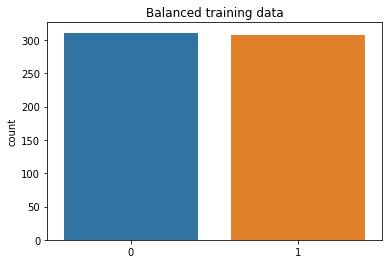

In [11]:
sns.countplot(y)
plt.title('Balanced training data')

In [12]:
rf = RandomForestClassifier(n_estimators=5, random_state=12)
recall_scores = cross_val_score(rf, x, y, scoring='recall', cv=5)
f1_scores = cross_val_score(rf, x,y, scoring='f1', cv=5)
print 'Recall scores: {}'.format(recall_scores)
print 'F1 scores: {}'.format(f1_scores)

Recall scores: [ 1.  1.  1.  1.  1.]
F1 scores: [ 1.  1.  1.  1.  1.]


### Results for training set

In [13]:
preds = cross_val_predict(rf, x, y, cv=5)
print 'Accuracy score: {}'.format(accuracy_score(y, preds))
print 'Recall score: {}'.format(recall_score(y, preds))
print 'Precision score: {}'.format(precision_score(y, preds))
print 'f1-score: {}'.format(f1_score(y, preds))

Accuracy score: 1.0
Recall score: 1.0
Precision score: 1.0
f1-score: 1.0


### Results for test set

In [14]:
rf.fit(x, y)
test_preds = rf.predict(x_test)
print 'Accuracy score: {}'.format(accuracy_score(y_test, test_preds))
print 'Recall score: {}'.format(recall_score(y_test, test_preds))
print 'Precision score: {}'.format(precision_score(y_test, test_preds))
print 'f1-score: {}'.format(f1_score(y_test, test_preds))

Accuracy score: 0.956204379562
Recall score: 0.5
Precision score: 0.333333333333
f1-score: 0.4


What happened? cross-validated score is almost 100% but test recall is only 50%. looks like model is over-fitting. But I did cross-validation to detect if my model was overfitting

Looks like there was information bleed from the validation set to the training set. 
The cross-validation was performed after upsampling, but the ideal way would be to perform oversampling of the training data in each cross-validation iteration. This would have prevented the data leakage from the validation set to the training set during cross-validation. 

### Oversampling in each cross-validation loop

In [15]:
kf = StratifiedKFold(n_splits=5, random_state=42)
cross_val_f1_score_lst = []
cross_val_accuracy_lst = []
cross_val_recall_lst = []
cross_val_precision_lst = []

for train_index, test_index in kf.split(x_train, y_train):
    # keeping validation set apart and oversampling in each iteration 
    train, test = x_train.iloc[train_index], x_train.iloc[test_index]
    target_train, target_test = y_train[train_index], y_train[test_index]
    target_train_malignant_indices = np.where(target_train == 1)[0]
    sample_indices = np.random.choice(target_train_malignant_indices, 220, replace=True)
    oversampled_data = train.iloc[sample_indices]
    # oversampled data appended to existing train set
    train = pd.concat([train, oversampled_data])
    target_train_sampled = target_train[sample_indices]
    target_train = np.append(target_train, target_train_sampled, axis=0)
    # training the model on oversampled 4 folds of training set
    rf = RandomForestClassifier(n_estimators=5, random_state=12)
    rf.fit(train, target_train)
    test_preds = rf.predict(test)
    cross_val_recall_lst.append(recall_score(target_test, test_preds))
    cross_val_accuracy_lst.append(accuracy_score(target_test, test_preds))
    cross_val_precision_lst.append(precision_score(target_test, test_preds))
    cross_val_f1_score_lst.append(f1_score(target_test, test_preds))
print 'Cross validated accuracy: {}'.format(np.mean(cross_val_accuracy_lst))
print 'Cross validated recall score: {}'.format(np.mean(cross_val_recall_lst))
print 'Cross validated precision score: {}'.format(np.mean(cross_val_precision_lst))
print 'Cross validated f1_score: {}'.format(np.mean(cross_val_f1_score_lst))

Cross validated accuracy: 0.987496947497
Cross validated recall score: 0.4
Cross validated precision score: 0.4
Cross validated f1_score: 0.4
